# Dataset

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from lifelines.datasets import load_rossi
from sksurv.metrics import concordance_index_censored

from utils.model import Model 

data = load_rossi()
data.dropna(inplace=True)
print(data.shape)
data.head()

2025-04-24 21:00:00.751551: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(432, 9)


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [2]:
event_col = "arrest"
duration_col = "week"

X = data.drop(columns=[event_col, duration_col])
X.shape

(432, 7)

# Train-test split 

In [3]:
from utils.data import train_test_splitting

train_idx, test_idx = train_test_splitting(
    np.arange(data.shape[0]), test_size=0.2, stratify=data[event_col].squeeze().astype(int)
)
# Data splits
data_train, data_test = data.iloc[train_idx], data.iloc[test_idx]
print(data_train.shape, data_test.shape)

(345, 9) (87, 9)


In [4]:
N_SPLITS = 2
DATA_SPLIT_IDX = np.array_split(np.arange(data_train.shape[0]), N_SPLITS)

In [5]:
duration_train = data_train[duration_col].to_numpy().squeeze()
duration_test = data_test[duration_col].to_numpy().squeeze()

event_train = data_train[event_col].to_numpy().squeeze()
event_test = data_test[event_col].to_numpy().squeeze()

In [6]:
from sksurv.util import Surv
# Create structured arrays
y_train = Surv.from_arrays(event=event_train, time=duration_train)
y_test = Surv.from_arrays(event=event_test, time=duration_test)
print(y_train.shape, y_test.shape)

(345,) (87,)


# Pre-processing

In [7]:
from utils.data import feature_scaling
# Scale features with Z-score transfrom 
X_train, X_test = feature_scaling(X.iloc[train_idx].values, X.iloc[test_idx].values)

In [8]:
from utils.data import init_knots
# Set knot locations 
knots = init_knots(duration_train, event_train, n_knots=5)
min(knots), max(knots)

(0.0, 3.9512437185814275)

# Initialize parameters

In [34]:
from utils.data import init_gamma, init_beta
from utils.splines import bspline_design_matrix

# Create one spline equation per time point 
D = bspline_design_matrix(np.log(duration_train), knots)

# Initialize gamma coefficients
gamma = init_gamma(D, duration_train)

# Initialize beta coefficients
beta = init_beta(X_train, y_train)

In [35]:
# Initialize global params
z_beta = np.zeros_like(beta)
z_gamma = np.zeros_like(gamma)
u_betas = [np.zeros_like(beta) for _ in range(N_SPLITS)]
u_gammas = [np.zeros_like(gamma) for _ in range(N_SPLITS)]

# Model fitting 

In [42]:
models = []
for _ in range(N_SPLITS):
    model_i = Model(epochs=5, knots=knots, learning_rate=0.01, l2_lambda=0)
    model_i.set_params({"beta": beta, "gamma": gamma})

    models.append(model_i)

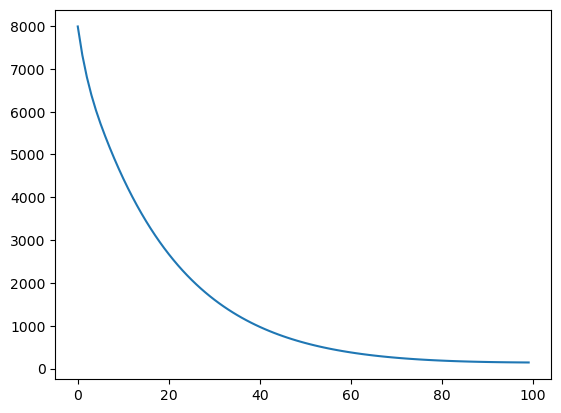

In [43]:
def server_admm_update(all_betas, all_gammas, u_betas, u_gammas):
    # Average to get new z (global parameters)
    z_beta = np.mean(all_betas, axis=0)
    z_gamma = np.mean(all_gammas, axis=0)

    # Update duals
    new_u_betas = [u + (b - z_beta) for b, u in zip(all_betas, u_betas)]
    new_u_gammas = [u + (g - z_gamma) for g, u in zip(all_gammas, u_gammas)]

    return z_beta, z_gamma, new_u_betas, new_u_gammas


losses = []
for _ in range(100):
    
    local_betas, local_gammas, last_local_losses = [], [], []
    for i in range(N_SPLITS):

        X_train_i = X_train[DATA_SPLIT_IDX[i]]
        y_train_i = y_train[DATA_SPLIT_IDX[i]]
        
        models[i].fit_fedadmm(
            X_train_i, y_train_i, z_beta, z_gamma, u_betas[i], u_gammas[i]
        )
        local_betas.append(models[i].beta)
        local_gammas.append(models[i].gamma)
        last_local_losses.append(models[i].losses[-1])
    
    losses.append(np.mean(last_local_losses))
    
    z_beta, z_gamma, u_betas, u_gammas = server_admm_update(local_betas, local_gammas, u_betas, u_gammas)

plt.figure()
plt.plot(losses)

# Global model

In [44]:
global_model = Model(epochs=0, knots=knots, learning_rate=0.01, l2_lambda=0)
global_model.set_params({"beta": z_beta, "gamma": z_gamma})

In [45]:
print(concordance_index_censored(event_train.astype(bool), duration_train, global_model.risk_score(X_train).squeeze()))
print(concordance_index_censored(event_test.astype(bool), duration_test, global_model.risk_score(X_test).squeeze()))

(0.6454424827687885, 17496, 9604, 31, 1016)
(0.602147417295415, 1037, 685, 1, 0)


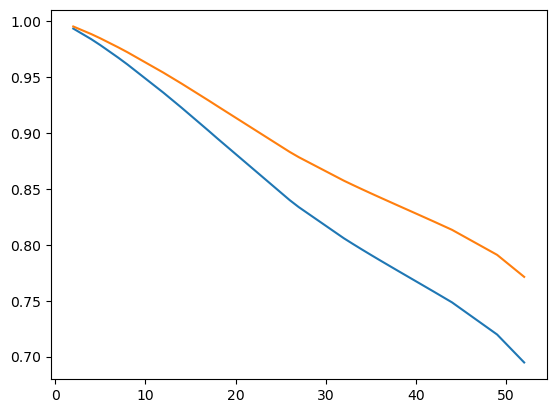

In [46]:
S0 = global_model.survival_curve(X_test[0], duration_test)
S1 = global_model.survival_curve(X_test[1], duration_test)

plt.figure()
idx = np.argsort(duration_test)
plt.plot(duration_test[idx], S0[idx, 0])
plt.plot(duration_test[idx], S1[idx, 0])